# Data Generation: Sliding Window Time Series
Compatible with Qiskit 1.2.4+

### Author
- **Jacob Cybulski**, jacob.cybulski[at]deakin.edu.au<br/>
    School of IT, SEBE, Deakin University, Melbourne, Vic, Australia

### Aims
> *This script aims to create and save a data set.*

### Note
> *<font color="tomato">When running this script, you are likely to obtain slightly different results each time.</font>*

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/envs/qiskit-gpu/lib/python311.zip',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11/site-packages',
 '.']

In [2]:
import os
import numpy as np
import pylab
import math
import json
import time

from IPython.display import clear_output
from qiskit_algorithms.utils import algorithm_globals

from utils.Target import *
from utils.Window import *
from utils.TS import *
from utils.Charts import *
from utils.Files import *

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
### Listing control
debug = True

### Software version
MAJOR = 9
MINOR = 0

### Constants
LOG_NAME = 'log_2'
CASE_NAME = 'sw'
DATA_NAME = '2_sins_sw'
DATA_PATH = f'{LOG_NAME}/data'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Show constants
(LOG_NAME, CASE_NAME, DATA_NAME,DATA_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, FIGURES_PATH)

('log_2',
 'sw',
 '2_sins_sw',
 'log_2/data',
 'log_2/training',
 'log_2/params',
 'log_2/analysis',
 'log_2/figures')

## Prepare windowed version of data
*Values need to be in [0, 1] range*

In [4]:
### Start random process

seed = 2022
algorithm_globals.random_seed = seed

### Data settings
samples_train = 50
samples_valid = 20
samples = samples_train+samples_valid
samples_hi_res = samples*2
train_pc = samples_train / samples
noise = 0

### Define the time series parameters
#   wind_size: sliding window size (which may be the same as number of qubits)
#   horizon:   the number of time events to look ahead (to forecast)
wind_size = 5
wind_step = 1
horizon = 1

### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

f = Target_2_sins()

In [5]:
### Create the continuous pure data, (X_valid, y_valid) ignored
X_all, y_all, _, _, _, _ = \
    target_split(f, samples, noise=noise, train_pc=1.0)#, seed=seed)

# Prepare X and y for training
X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = \
    Xy_wind_split(y_all, wind_size, wind_step, horizon, train_pc)

In [6]:
### All created files have the following codes:
#   t: training sample size
#   v: validation sample size
#   z: level of noise injected
#   w: window size
#   s: window step size
#   h: horizon size
DATA_PREF = f'{DATA_NAME}_t{samples_train}_v{samples_valid}_z{noise}_w{wind_size}_s{wind_step}_h{horizon}'
DATA_PREF

'2_sins_sw_t50_v20_z0_w5_s1_h1'

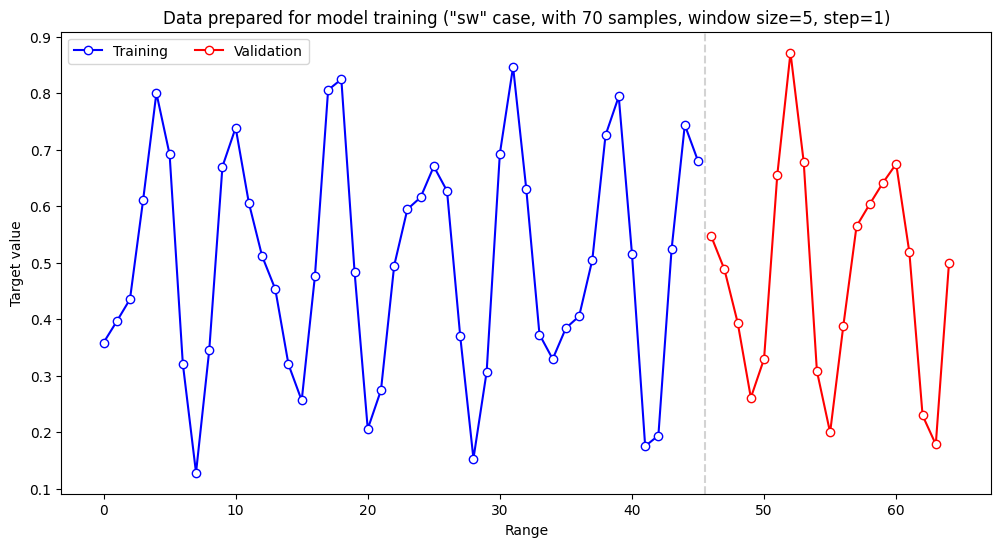

In [7]:
### Plot trainig and validation/test data partitions
#   Note that we will not use the X coordinates

y_train_flat_ts = ts_wind_flatten_avg(y_train_ts, wind_step)
y_valid_flat_ts = ts_wind_flatten_avg(y_valid_ts, wind_step)
y_list = [y_train_flat_ts, y_valid_flat_ts]
X_list = [0, len(y_train_flat_ts)]

print()
multi_plot_flat_ts(y_list, X_list=X_list, 
    colors = ['blue', 'red'], marker_colors=['white', 'white', 'lightblue', 'mistyrose'],
    labels = ['Training', 'Validation'], #ylim=(0.1, 1),
    lines = ['solid', 'solid'], markers = ['o', 'o'], legend_cols=2,
    title=f'Data prepared for model training ("{CASE_NAME}" case, with {samples} samples, window size={wind_size}, step={wind_step})',
    save_plot=f'{FIGURES_PATH}/data_{DATA_PREF}/train_and_valid.eps')
print()

In [8]:
from pprint import pprint

### Show a sample of data
print('\nSample of X_all (5 records, will be ignored):\n')
pprint(X_all[0:5])
print('\nSample of y_all (20 records):\n')
pprint(y_all[0:20])
print('\nTS X_train_ts examples (5 records):\n')
pprint(X_train_ts[0:5,:])
print('\nTS y_train_ts examples (5 records):\n')
pprint(y_train_ts[0:5,:])
print('\nTS(X, y) train shape:', X_train_ts.shape, y_train_ts.shape)
print('TS(X, y) valid shape:', X_valid_ts.shape, y_valid_ts.shape, '\n')


Sample of X_all (5 records, will be ignored):

array([[-6.28318531],
       [-6.10106399],
       [-5.91894268],
       [-5.73682137],
       [-5.55470005]])

Sample of y_all (20 records):

array([0.5       , 0.82166007, 0.7704136 , 0.48181766, 0.32499393,
       0.35846391, 0.396177  , 0.43535716, 0.61185817, 0.80051322,
       0.69182409, 0.32134849, 0.1281973 , 0.34493183, 0.67024666,
       0.73899214, 0.60587504, 0.51189238, 0.45321367, 0.31980653])

TS X_train_ts examples (5 records):

array([[0.5       , 0.82166007, 0.7704136 , 0.48181766, 0.32499393],
       [0.82166007, 0.7704136 , 0.48181766, 0.32499393, 0.35846391],
       [0.7704136 , 0.48181766, 0.32499393, 0.35846391, 0.396177  ],
       [0.48181766, 0.32499393, 0.35846391, 0.396177  , 0.43535716],
       [0.32499393, 0.35846391, 0.396177  , 0.43535716, 0.61185817]])

TS y_train_ts examples (5 records):

array([[0.35846391],
       [0.396177  ],
       [0.43535716],
       [0.61185817],
       [0.80051322]])

TS(X, y) tr

## Save training data

In [9]:
### Define file names
# Include TS: X_train_ts, y_train_ts, X_valid_ts, y_valid_ts

x_all_fpath = f'{DATA_PATH}/{DATA_PREF}/x_all.arr'
y_all_fpath = f'{DATA_PATH}/{DATA_PREF}/y_all.arr'

x_train_ts_fpath = f'{DATA_PATH}/{DATA_PREF}/x_train_ts.arr'
y_train_ts_fpath = f'{DATA_PATH}/{DATA_PREF}/y_train_ts.arr'
x_valid_ts_fpath = f'{DATA_PATH}/{DATA_PREF}/x_valid_ts.arr'
y_valid_ts_fpath = f'{DATA_PATH}/{DATA_PREF}/y_valid_ts.arr'

data_info_fpath = f'{DATA_PATH}/{DATA_PREF}/info.json'
data_info_fpath

'log_2/data/2_sins_sw_t50_v20_z0_w5_s1_h1/info.json'

In [10]:
## Save training parameters
### Save info details
data_info = \
    {'data_name':DATA_NAME, 
     'major_version':MAJOR, 
     'minor_version':MINOR,
     'data_train':samples_train,
     'data_valid':samples_valid,
     'data_noise':noise,
     'wind_size':wind_size,
     'wind_step':wind_step,
     'wind_horizon':horizon,
     'seed':seed}

### Saving the info file
write_json_file(data_info_fpath, data_info)
    
print(f'\nSaved time series info in file "{data_info_fpath}":\n')
for k in data_info.keys():
    print(f'\tinfo[{k}] = {data_info[k]}')
print()


Saved time series info in file "log_2/data/2_sins_sw_t50_v20_z0_w5_s1_h1/info.json":

	info[data_name] = 2_sins_sw
	info[major_version] = 9
	info[minor_version] = 0
	info[data_train] = 50
	info[data_valid] = 20
	info[data_noise] = 0
	info[wind_size] = 5
	info[wind_step] = 1
	info[wind_horizon] = 1
	info[seed] = 2022



In [11]:
### Save the history file
write_ts_file(x_all_fpath, X_all)
write_ts_file(y_all_fpath, y_all)
write_ts_file(x_train_ts_fpath, X_train_ts)
write_ts_file(y_train_ts_fpath, y_train_ts)
write_ts_file(x_valid_ts_fpath, X_valid_ts)
write_ts_file(y_valid_ts_fpath, y_valid_ts)
print(f'\nSaved time series data\n')


Saved time series data



## System details

In [12]:
!pip list | grep -e qiskit -e torch

qiskit                    1.2.4
qiskit-aer-gpu            0.15.1
qiskit-algorithms         0.3.1
qiskit-ibm-runtime        0.32.0
qiskit-machine-learning   0.7.2
qiskit-optimization       0.6.1
